# Company Bankruptcy Prediction

### Cel biznesowy
Predykcja brankructwa firm na podstawie parametrów ekonomicznych

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [262]:
db_raw = pd.read_csv('./db/data.csv') 
db_raw.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## EDA

Sprawdzenie wartości null w danych kolumnach

**Wniosek**: brak wratości null

In [ ]:
db_raw.describe()

In [ ]:
db_raw.info()

Sprawdzenie ile firm zbankrutowało, a ile nie

In [ ]:
db_raw['Bankrupt?'].value_counts()

Wyrzucenie ' Net Income Flag' - 0 dla każdego recordu

In [263]:
db = db_raw.drop([' Net Income Flag'], axis=1)

Podzielenie na zbiór treningowy i walidacyjny do sprawdzenia poprawności założeń


In [264]:
target = db['Bankrupt?']
db = db.drop(['Bankrupt?'], axis=1)

In [265]:
x_temp, x_valid, y_temp, y_valid = train_test_split(db, target, test_size=0.3, stratify = target, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.3, stratify = y_temp, random_state = 42)

Sprawdzenie zależności miedzy bankrupctwem a pozostałymi parametrami celem wyszczególenia tych najbardziej istotnych

Za pomocą boxplot

In [ ]:
for i in range(10, 20):
    fig, ax = plt.subplots(figsize=(25,8))
    sns.boxplot(x=y_train, y=x_train[x_train.columns[i]], ax=ax)
    ax.set_title(f'Boxplot of {x_train.columns[i]}')
    print(i)
    plt.show()

oraz za pomocą heatmapy korelacji

In [ ]:
spearman_corr = db.corr('spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

plt.figure(figsize=(25, 20))
sns.heatmap(spearman_corr, mask=mask, square=True, linewidths=0.5, cmap='coolwarm')
plt.show()

Wybór kolumn z najbardziej widocznymi zależnościami do dalszych badań korelacji

In [ ]:
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).head(15))
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).tail(30))

Wizualizacja kilku ciekawych parametrów za pomocą boxplotów

In [ ]:
plt.subplots(ncols=5, figsize=(25,8))

sns.boxplot(x='Bankrupt?', y=" Persistent EPS in the Last Four Seasons", data=db, ax=plt.subplot(1, 5, 1))
sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=db, ax=plt.subplot(1, 5, 2))
sns.boxplot(x='Bankrupt?', y=" ROA(B) before interest and depreciation after tax", data=db, ax=plt.subplot(1, 5, 3))
sns.boxplot(x='Bankrupt?', y=" Net Value Per Share (B)", data=db, ax=plt.subplot(1, 5, 4))
sns.boxplot(x='Bankrupt?', y=" Equity to Long-term Liability", data=db, ax=plt.subplot(1, 5, 5))

Obsługa outlierów

In [266]:
for column in x_train.columns:
    upper_lim = x_train[column].quantile(.99)
    lower_lim = x_train[column].quantile(.01)

    x_train.loc[x_train[column] > upper_lim, column] = upper_lim
    x_train.loc[x_train[column] < lower_lim, column] = lower_lim

    x_test.loc[x_test[column] > upper_lim, column] = upper_lim
    x_test.loc[x_test[column] < lower_lim, column] = lower_lim
    
    x_valid.loc[x_valid[column] > upper_lim, column] = upper_lim
    x_valid.loc[x_valid[column] < lower_lim, column] = lower_lim

Logarytm kolumn

In [267]:
for column in x_train.columns:
    skew = x_train[column].skew()
    if skew > 0.5 or skew < -0.5:
        x_train[column] = np.log1p(x_train[column])  
        x_test[column] = np.log1p(x_test[column])  
        x_valid[column] = np.log1p(x_valid[column])  

Normalizacja

In [268]:
scaler = MinMaxScaler()
scaler.fit_transform(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
x_valid = pd.DataFrame(scaler.transform(x_valid), columns=x_valid.columns)

Wybór najbardziej istotnych cech

In [269]:
rf_model = RandomForestClassifier(random_state=69)
rf_model.fit(x_train, y_train)
perm_importance = permutation_importance(rf_model, x_train, y_train, n_repeats=100, random_state=69)

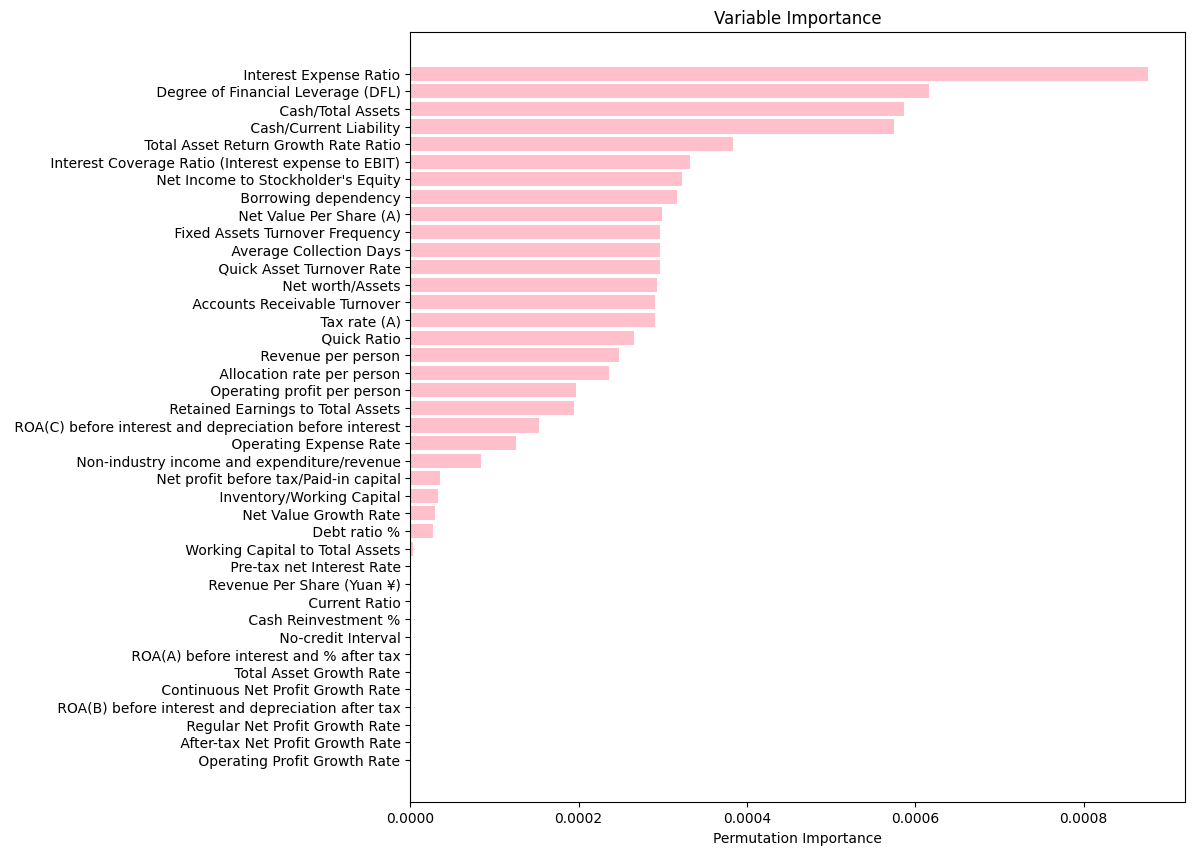

In [270]:
sorted_idx = perm_importance.importances_mean.argsort()
top_vars = 40

x_test = x_test[x_train.columns[sorted_idx][-top_vars:]]
x_valid = x_valid[x_train.columns[sorted_idx][-top_vars:]]
x_train = x_train[x_train.columns[sorted_idx][-top_vars:]]

plt.figure(figsize=(10, 10))
plt.barh(range(top_vars), perm_importance.importances_mean[sorted_idx][-top_vars:], color='pink')
plt.yticks(range(top_vars), x_train.columns)
plt.xlabel('Permutation Importance')
plt.title('Variable Importance')
plt.show()

Pierwsze testowanie modeli: LogisticRegression

In [ ]:
# param_distributions = {
#             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#             'penalty': ['l1', 'l2'],
#             'class_weight': ['balanced',None],
#             'max_iter': list(range(100,800,100)),
#             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# random_search = RandomizedSearchCV(
#     estimator=LogisticRegression(),
#     param_distributions=param_distributions,
#     scoring='roc_auc',
#     n_iter=10,
#     cv=5,
#     random_state=420,
#     n_jobs=-1
# )

# random_search.fit(x_train, y_train)

# best_estimator = random_search.best_estimator_

In [282]:
param_distributions = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2'],
            'class_weight': ['balanced',None],
            'max_iter': list(range(100,800,100)),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\Loc

In [281]:
from sklearn.metrics import confusion_matrix

y_pred_log_reg = best_estimator.predict(x_test)

precision = precision_score(y_test, y_pred_log_reg)
accuracy = accuracy_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
gini = 2 * roc_auc_log_reg - 1

print('-'*30)
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print('-'*30)
print(f'ROC_AUC: {roc_auc_log_reg}')
print(f'GINI: {gini}')
print(confusion_matrix(y_test, y_pred_log_reg))

------------------------------
accuracy: 0.8589385474860335
precision: 0.1608695652173913
recall: 0.8043478260869565
f1: 0.26811594202898553
------------------------------
ROC_AUC: 0.8325490934186587
GINI: 0.6650981868373174
[[1193  193]
 [   9   37]]


In [260]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features' : ['auto', 'sqrt', 'log2'],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", l

In [261]:
from sklearn.metrics import confusion_matrix

y_pred_rand_for = best_estimator.predict(x_test)

precision = precision_score(y_test, y_pred_rand_for)
accuracy = accuracy_score(y_test, y_pred_rand_for)
recall = recall_score(y_test, y_pred_rand_for)
f1 = f1_score(y_test, y_pred_rand_for)

roc_auc_rand_for = roc_auc_score(y_test, y_pred_rand_for)
gini = 2 * roc_auc_rand_for - 1

print('-'*30)
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print('-'*30)
print(f'ROC_AUC: {roc_auc_rand_for}')
print(f'GINI: {gini}')
print(confusion_matrix(y_test, y_pred_rand_for))

------------------------------
accuracy: 0.9511173184357542
precision: 0.35714285714285715
recall: 0.6521739130434783
f1: 0.46153846153846156
------------------------------
ROC_AUC: 0.8066064370412196
GINI: 0.6132128740824392
[[1332   54]
 [  16   30]]


In [286]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint

In [291]:
gbm = GradientBoostingClassifier(random_state=42)

xgb = XGBClassifier(random_state=42)

lgbm = LGBMClassifier(random_state=42)

catboost = CatBoostClassifier(random_state=42, verbose=0)

models = [gbm, xgb, lgbm, catboost]
model_names = ['GBM', 'XGBoost', 'LightGBM', 'CatBoost']
auc_scores = []


param_distributions = {
    'GBM': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(2, 10)
    },
    'XGBoost': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(2, 10)
    },
    'LightGBM': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(2, 10)
    },
    'CatBoost': {
        'iterations': randint(50, 300),
        'learning_rate': uniform(0.01, 0.3),
        'depth': randint(2, 10)
    }
}

# Przeprowadzanie RandomizedSearchCV dla każdego modelu
for name, model in zip(model_names, models):
    search = RandomizedSearchCV(model, param_distributions=param_distributions[name], n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, random_state=42)
    search.fit(x_train, y_train)
    y_pred = search.best_estimator_.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)

# Wyświetlanie wyników
for name, score in zip(model_names, auc_scores):
    print(f'{name} AUC-ROC: {score}')

Best parameters for GBM: {'learning_rate': 0.12236203565420874, 'max_depth': 6, 'n_estimators': 64}
Best score for GBM: 0.9342542268232881
Best parameters for XGBoost: {'learning_rate': 0.22959818254342154, 'max_depth': 6, 'n_estimators': 70}
Best score for XGBoost: 0.9421625199631334
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 108, number of negative: 3233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10197
[LightGBM] [Info] Number of data points in the train set: 3341, number of used features: 40
[LightGBM] [Info]

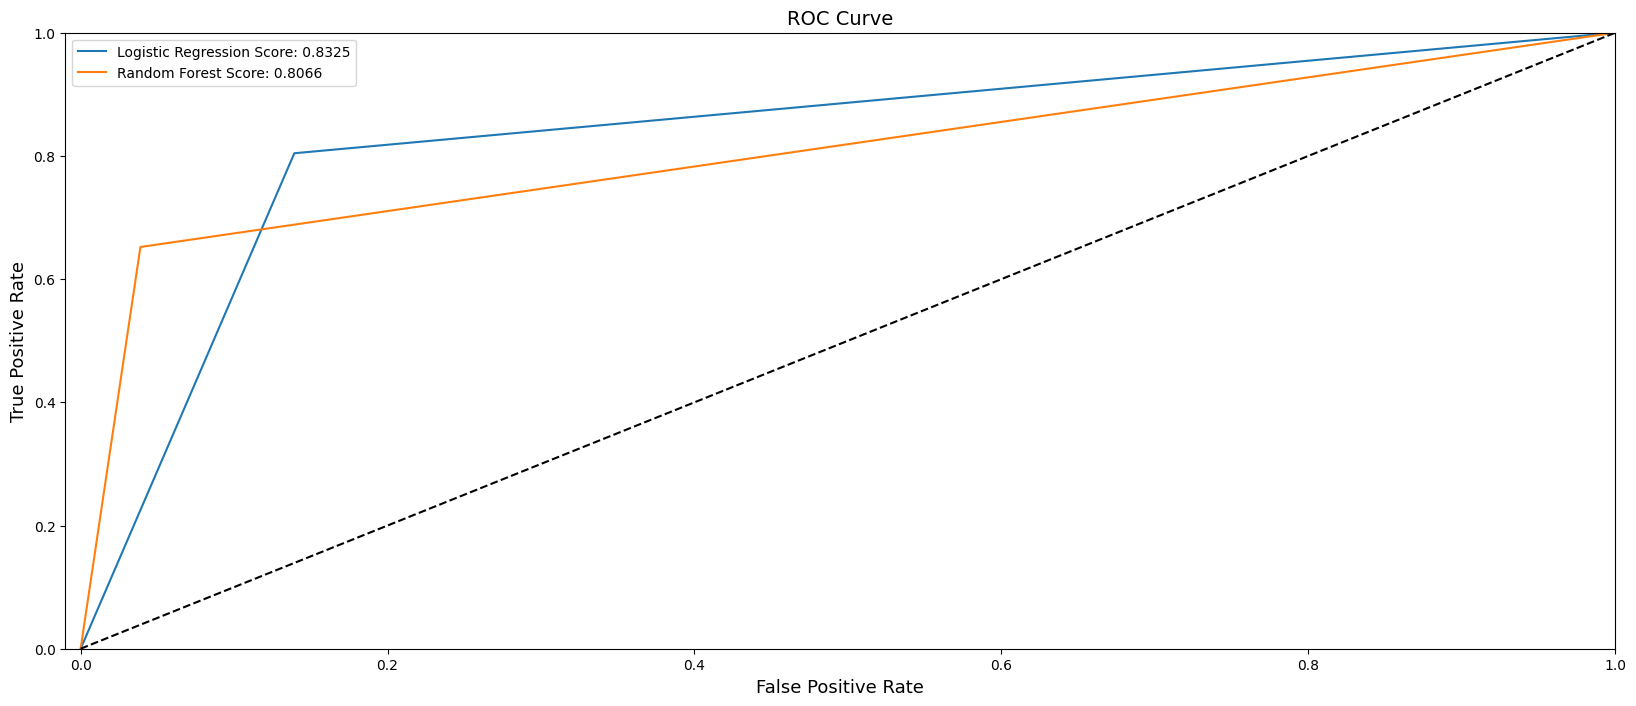

In [283]:
from sklearn.metrics import roc_curve

log_fpr, log_tpr, log_thresold = roc_curve(y_test, y_pred_log_reg)
for_fpr, for_tpr, for_thresold = roc_curve(y_test, y_pred_rand_for)

plt.figure(figsize=(20,8))
plt.title('ROC Curve', fontsize=14)
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression Score: {roc_auc_log_reg.round(4)}')
# plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_xgb)))
# plt.plot(cat_fpr, cat_tpr, label='CatBoost Score: {:.4f}'.format(roc_auc_score(y_val_sm, smote_prediction_cat)))
plt.plot(for_fpr, for_tpr, label=f'Random Forest Score: {roc_auc_rand_for.round(4)}')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend()
    
plt.show()

7
